[*********************100%***********************]  1 of 1 completed


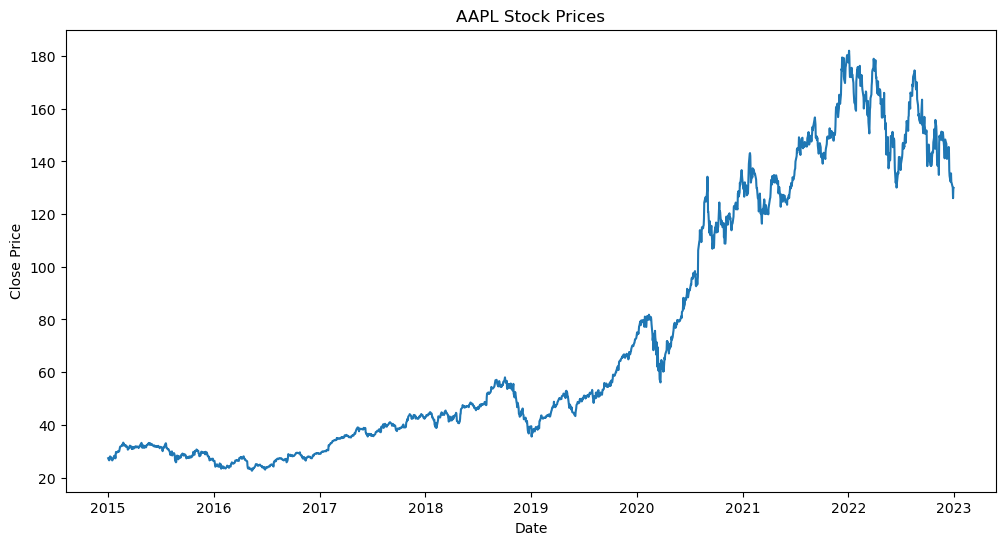

C:\Users\sarav\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.0329
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0010
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 4.7561e-04
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 3.6036e-04
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 3.2256e-04
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 3.0334e-04
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.2388e-04
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 3.3970e-04
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2.7689e-04
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 2.7564e-04
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


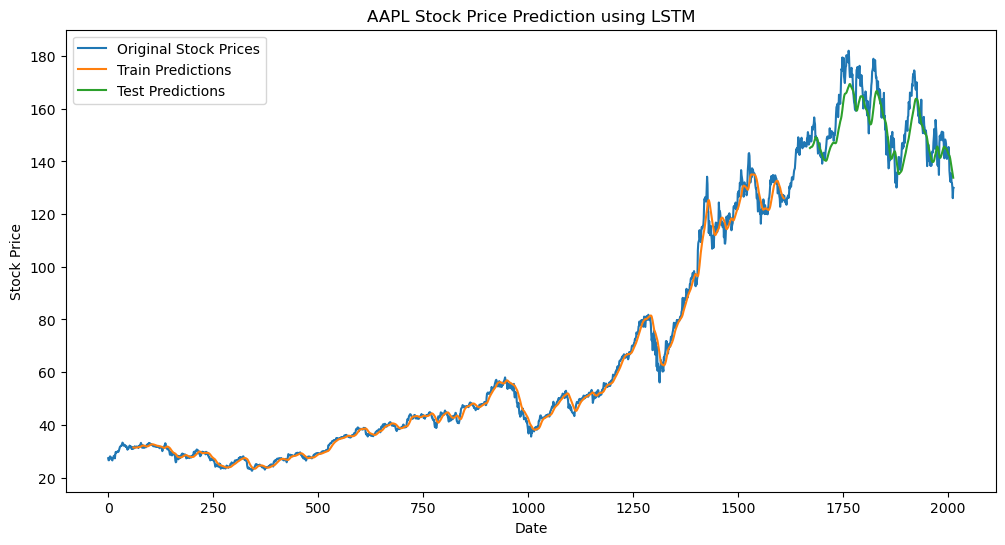

Root Mean Squared Error (RMSE): 150.6125


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf

ticker = 'AAPL'
df = yf.download(ticker, start='2015-01-01', end='2023-01-01')

df = df[['Close']]

plt.figure(figsize=(12, 6))
plt.plot(df['Close'])
plt.title(f'{ticker} Stock Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

data = df.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60  
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=64, epochs=10)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(scaled_data), label="Original Stock Prices")
plt.plot(train_plot, label="Train Predictions")
plt.plot(test_plot, label="Test Predictions")
plt.title(f'{ticker} Stock Price Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
